# Joint analysis of paired and unpaired multiomic data with MultiVI

MultiVI is used for the joint analysis of scRNA and scATAC-seq datasets that were jointly profiled (multiomic / paired) and single-modality datasets (only scRNA or only scATAC). MultiVI uses the paired data as an anchor to align and merge the latent spaces learned from each individual modality.

This tutorial walks through how to read multiomic data, create a joint object with paired and unpaired data, set-up and train a MultiVI model, visualize the resulting latent space, and run differential analyses. 

In [2]:
import sys

# If True, will install via pypi, else will install from source
stable = True
IN_COLAB = "google.colab" in sys.modules

if IN_COLAB and stable:
    !pip install --quiet scvi-tools
elif IN_COLAB and not stable:
    !pip install --quiet --upgrade jsonschema
    !pip install --quiet git+https://github.com/yoseflab/scvi-tools@master#egg=scvi-tools[tutorials]

     |████████████████████████████████| 56 kB 2.4 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
nbclient 0.5.4 requires jupyter-client>=6.1.5, but you have jupyter-client 5.3.5 which is incompatible.
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 813 kB 5.1 MB/s 
     |████████████████████████████████| 678 kB 55.7 MB/s 
     |████████████████████████████████| 127 kB 62.0 MB/s 
     |████████████████████████████████| 209 kB 56.0 MB/s 
     |████████████████████████████████| 243 kB 55.6 MB/s 
     |████████████████████████████████| 1.4 MB 35.2 MB/s 
     |████████████████████████████████| 8.8 MB 28.2 MB/s 
     |████████████████████████████████| 2.0 MB 38.3 MB/s 
     |████████████████████████████████| 41 kB 103 kB/s 
     |██████████████

## Data acquisition
First we download a sample multiome dataset from 10X. We'll use this throughout this tutorial.
Importantly, MultiVI assumes that there are shared features between the datasets. This is trivial for gene expression datasets, which generally use the same set of genes as features. For ATAC-seq peaks, this is less trivial, and often requires preprocessing steps with other tools to get all datasets to use a shared set of peaks. That can be achieved with tools like SnapATAC, ArchR, and CellRanger in the case of 10X data.

<div class="alert alert-info">
Important

MultiVI requires the datasets to use shared features. scATAC-seq datasets need to be processed to use a shared set of peaks.

</div>

In [3]:
!wget https://cf.10xgenomics.com/samples/cell-arc/2.0.0/pbmc_unsorted_10k/pbmc_unsorted_10k_filtered_feature_bc_matrix.tar.gz
!sudo tar -xvf pbmc_unsorted_10k_filtered_feature_bc_matrix.tar.gz
!gunzip -f filtered_feature_bc_matrix/*.gz

--2021-08-21 17:49:29--  https://cf.10xgenomics.com/samples/cell-arc/2.0.0/pbmc_unsorted_10k/pbmc_unsorted_10k_filtered_feature_bc_matrix.tar.gz
Resolving cf.10xgenomics.com (cf.10xgenomics.com)... 104.18.0.173, 104.18.1.173, 2606:4700::6812:ad, ...
Connecting to cf.10xgenomics.com (cf.10xgenomics.com)|104.18.0.173|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 375260850 (358M) [application/x-tar]
Saving to: ‘pbmc_unsorted_10k_filtered_feature_bc_matrix.tar.gz’

pbmc_unsorted_10k_f 100%[===================>] 357.88M  40.8MB/s    in 9.1s    

2021-08-21 17:49:39 (39.4 MB/s) - ‘pbmc_unsorted_10k_filtered_feature_bc_matrix.tar.gz’ saved [375260850/375260850]

filtered_feature_bc_matrix/
filtered_feature_bc_matrix/barcodes.tsv.gz
filtered_feature_bc_matrix/matrix.mtx.gz
filtered_feature_bc_matrix/features.tsv.gz


In [4]:
import scvi
import anndata
import scipy
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt

scvi.settings.seed = 420

/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


## Data Processing
Next, we'll read the data into an Anndata object. We'll then split the data to three datasets, and remove some modality-specific data from parts of the dataset, to demonstrate how MultIVI mixes multimodal and single-modal data.
The data has 12012 cells, we'll use 4004 for each dataset.

Reading the data into an AnnData object can be done with the `read_10x_multiome` function:

In [5]:
# read multiomic data
adata = scvi.data.read_10x_multiome("filtered_feature_bc_matrix")
adata.var_names_make_unique()

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


We can now split the dataset to three datasets, and remove a modality from two of them, so we'll have equal-sized (4004 cells in each) datasets with multiome, expression-only, and accessibility-only observations:

In [6]:
# split to three datasets by modality (RNA, ATAC, Multiome), and corrupt data 
# by remove some data to create single-modality data
n = 4004
adata_rna = adata[:n, adata.var.modality == "Gene Expression"].copy()
adata_paired = adata[n:2 * n].copy()
adata_atac = adata[2 * n:, adata.var.modality == "Peaks"].copy()

We can then use the `organize_multiome_anndatas` function to orgnize these three datasets into a single Multiome dataset.
This function sorts and orders the data from the multi-modal and modality-specific AnnDatas into a single AnnData (aligning the features, padding missing modalities with 0s, etc). 

In [7]:
# We can now use the organizing method from scvi to concatenate these anndata
adata_mvi = scvi.data.organize_multiome_anndatas(adata_paired, adata_rna, adata_atac)

Note that `organize_multiome_anndatas` adds an annotation to the cells to indicate which modality they originate from:

In [8]:
adata_mvi.obs

,batch_id,modality
CCGCTAAAGGGCCATC_paired,1,paired
CCGCTAAAGTCTTGAA_paired,1,paired
CCGCTAAAGTTAGACC_paired,1,paired
CCGCTAAAGTTCCCAC_paired,1,paired
CCGCTAAAGTTTGCGG_paired,1,paired
...,...,...
TTTGTTGGTACGCGCA_accessibility,1,accessibility
TTTGTTGGTATTTGCC_accessibility,1,accessibility
TTTGTTGGTGATTACG_accessibility,1,accessibility
TTTGTTGGTTTCAGGA_accessibility,1,accessibility


<div class="alert alert-info">
Important

MultiVI requires the features to be ordered so that genes appear before genomic regions. This must be enforced by the user.

</div>

MultiVI requires the features to be ordered, such that genes appear before genomic regions. In this case this is already the case, but it's always good to verify:

In [9]:
adata_mvi = adata_mvi[:, adata_mvi.var["modality"].argsort()].copy()
adata_mvi.var

,ID,modality,chr,start,end
MIR1302-2HG,ENSG00000243485,Gene Expression,chr1,29553,30267
AL391261.2,ENSG00000258847,Gene Expression,chr14,66004522,66004523
FUT8-AS1,ENSG00000276116,Gene Expression,chr14,65412689,65412690
FUT8,ENSG00000033170,Gene Expression,chr14,65410591,65413008
AL355076.2,ENSG00000258760,Gene Expression,chr14,65302679,65318790
...,...,...,...,...,...
chr15:101277030-101277907,chr15:101277030-101277907,Peaks,chr15,101277030,101277907
chr15:101257856-101258771,chr15:101257856-101258771,Peaks,chr15,101257856,101258771
chr15:101251516-101252373,chr15:101251516-101252373,Peaks,chr15,101251516,101252373
chr15:101397608-101398445,chr15:101397608-101398445,Peaks,chr15,101397608,101398445


We also filter features to remove those that appear in fewer than 1% of the cells

In [10]:
print(adata_mvi.shape)
sc.pp.filter_genes(adata_mvi, min_cells=int(adata_mvi.shape[0] * 0.01))
print(adata_mvi.shape)

(12012, 148458)
(12012, 80878)


## Setup and Training MultiVI
We can now set up and train the MultiVI model!

First, we need to setup the Anndata object using the `setup_anndata` function. At this point we specify any batch annotation that the model would account for.
**Importantly**, the main batch annotation, specific by `batch_key`, should correspond to the modality of the cells.

Other batch annotations (e.g if there are multiple ATAC batches) should be provided using the `categorical_covariate_keys`.

The actual values of categorical covariates (include `batch_key`) are not important, as long as they are different for different samples.
I.e it is not important to call the expression-only samples "expression", as long as they are called something different than the multi-modal and accessibility-only samples.

<div class="alert alert-info">
Important

MultiVI requires the main batch annotation to correspond to the modality of the samples. Other batch annotation, such as in the case of multiple RNA-only batches, can be specified using `categorical_covariate_keys`.

</div>

In [11]:
scvi.data.setup_anndata(adata_mvi, batch_key='modality')

INFO     Using batches from adata.obs["modality"]                                            
INFO     No label_key inputted, assuming all cells have same label                           
INFO     Using data from adata.X                                                             
INFO     Computing library size prior per batch                                              
INFO     Successfully registered anndata object containing 12012 cells, 80878 vars, 3        
         batches, 1 labels, and 0 proteins. Also registered 0 extra categorical covariates   
         and 0 extra continuous covariates.                                                  
INFO     Please do not further modify adata until model is trained.                          


When creating the object, we need to specify how many of the features are genes, and how many are genomic regions. This is so MultiVI can determine the exact architecture for each modality.

In [12]:
mvi = scvi.model.MULTIVI(
    adata_mvi, 
    n_genes=(adata_mvi.var['modality']=='Gene Expression').sum(),
    n_regions=(adata_mvi.var['modality']=='Peaks').sum(),
)
mvi.train()

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 232/500:  46%|████▋     | 232/500 [32:57<38:04,  8.52s/it, loss=6.47e+03, v_num=1]


## Save and Load MultiVI models

Saving and loading models is similar to all other scvi-tools models, and is very straight forward:

In [13]:
mvi.save("trained_multivi")

In [14]:
mvi = scvi.model.MULTIVI.load("trained_multivi", adata_mvi)

INFO     Using data from adata.X                                                             
INFO     Computing library size prior per batch                                              
INFO     Registered keys:['X', 'batch_indices', 'local_l_mean', 'local_l_var', 'labels']     
INFO     Successfully registered anndata object containing 12012 cells, 80878 vars, 3        
         batches, 1 labels, and 0 proteins. Also registered 0 extra categorical covariates   
         and 0 extra continuous covariates.                                                  


## Extracting and visualizing the latent space

We can now use the `get_latent_representation` to get the latent space from the trained model, and visualize it using scanpy functions:

... storing 'modality' as categorical
... storing 'modality' as categorical
... storing 'chr' as categorical


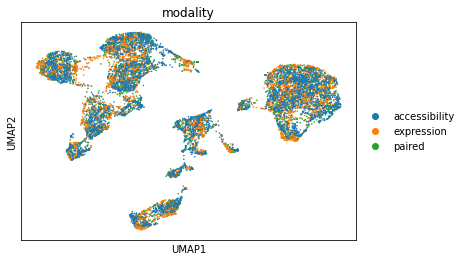

In [15]:
adata_mvi.obsm["MultiVI_latent"] = mvi.get_latent_representation()
sc.pp.neighbors(adata_mvi, use_rep="MultiVI_latent")
sc.tl.umap(adata_mvi, min_dist=0.2)
sc.pl.umap(adata_mvi, color='modality')

## Impute missing modalities

In a well-mixed space, MultiVI can seamlessly impute the missing modalities for single-modality cells.
First, imputing expression and accessibility is done with `get_normalized_expression` and `get_accessibility_estimates`, respectively.

We'll demonstrate this by imputing gene expression for all cells in the dataset (including those that are ATAC-only cells):

In [16]:
imputed_expression = mvi.get_normalized_expression()

We can demonstrate this on some known marker genes:


First, T-cell marker CD3. 

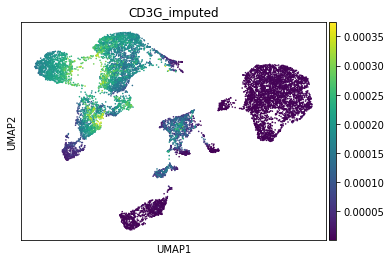

In [17]:
gene_idx = np.where(adata_mvi.var.index == "CD3G")[0]
adata_mvi.obs["CD3G_imputed"] = imputed_expression[:, gene_idx]
sc.pl.umap(adata_mvi, color='CD3G_imputed')

Next, NK-Cell marker gene NCAM1 (CD56):

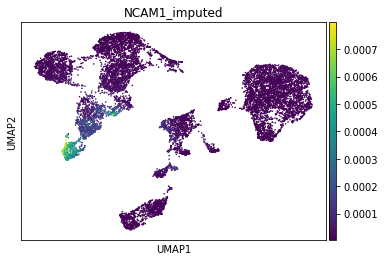

In [18]:
gene_idx = np.where(adata_mvi.var.index == "NCAM1")[0]
adata_mvi.obs["NCAM1_imputed"] = imputed_expression[:, gene_idx]
sc.pl.umap(adata_mvi, color='NCAM1_imputed')

Finally, B-Cell Marker CD19:

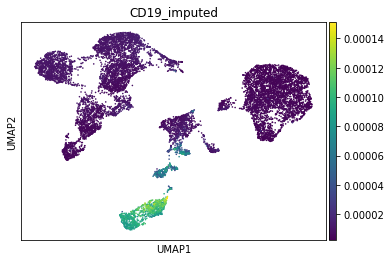

In [19]:
gene_idx = np.where(adata_mvi.var.index == "CD19")[0]
adata_mvi.obs["CD19_imputed"] = imputed_expression[:, gene_idx]
sc.pl.umap(adata_mvi, color='CD19_imputed')

All three marker genes clearly identify their respective populations. Importantly, the imputed gene expression profiles are stable and consistent within that population, **even though many of those cells only measured the ATAC profile of those cells**.